<a href="https://colab.research.google.com/github/nv-hiep/ImageDenoising/blob/main/ImageDenoisingAutoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image Denoising using Autoencoders**

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Reshape, Input
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Dropout, ActivityRegularization
from keras.layers import LSTM, RepeatVector, TimeDistributed, GaussianNoise

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    # plt.axis('off')

# Data

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train_full = X_train_full / 255.
X_test       = X_test / 255.

In [ ]:
print('X_train_full.shape: ', X_train_full.shape)
print('y_train_full.shape: ', y_train_full.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train_full.shape:  (60000, 28, 28)
y_train_full.shape:  (60000,)
X_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)


In [ ]:
train_size = 50_000

In [ ]:
X_train = X_train_full[:train_size]
X_valid = X_train_full[train_size:]

y_train = y_train_full[:train_size]
y_valid = y_train_full[train_size:]

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_valid.shape: ', X_valid.shape)
print('y_valid.shape: ', y_valid.shape)

X_train.shape:  (50000, 28, 28)
y_train.shape:  (50000,)
X_valid.shape:  (10000, 28, 28)
y_valid.shape:  (10000,)


In [ ]:
def show_reconstructions(model, images=X_test, n_images=5):
  '''
  First row: real images
  Second row: reconstructed images
  '''
  reconstructions = model.predict(images[:n_images])

  plt.figure(figsize=(n_images * 1.5, 3))
  # plt.title('Image reconstruction from Stacked Autoencoder')
  for img_id in range(n_images):
    plt.subplot(2, n_images, 1 + img_id)
    plot_image(images[img_id])
    plt.subplot(2, n_images, 1 + n_images + img_id)
    plot_image(reconstructions[img_id])
  plt.show()

# Denoising Autoencoders

Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. This idea has been around since the 1980s (e.g., it is mentioned in Yann LeCun’s 1987 master’s thesis). In a 2008 paper, Pascal Vincent et al. showed that autoencoders could also be used for feature extraction. In a 2010 paper, Vincent et al. introduced stacked denoising autoencoders.

The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched-off inputs, just like in dropout.

The implementation is straightforward: it is a regular stacked autoencoder with an additional Dropout layer applied to the encoder’s inputs (or you could use a GaussianNoise layer instead). Recall that the Dropout layer is only active during training (and so is the GaussianNoise layer):

## With a GaussianNoise layer

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = Sequential()
denoising_encoder.add( Flatten(input_shape=[28,28]) )
denoising_encoder.add( GaussianNoise(0.2) )
denoising_encoder.add( Dense(100, activation='selu') )
denoising_encoder.add( Dense(30, activation='selu'))

denoising_decoder = Sequential()
denoising_decoder.add( Dense(100, activation='selu', input_shape=[30]) )
denoising_decoder.add( Dense(28*28, activation='sigmoid') )
denoising_decoder.add( Reshape([28,28]) )

denoising_autoencoder = Sequential([denoising_encoder, denoising_decoder])
denoising_autoencoder.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=1.0), metrics=['binary_accuracy'])

In [ ]:
denoising_encoder.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_19 (Dense)             (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [ ]:
denoising_decoder.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_21 (Dense)             (None, 784)               79184     
_________________________________________________________________
reshape_10 (Reshape)         (None, 28, 28)            0         
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


In [ ]:
denoising_autoencoder.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_34 (Sequential)   (None, 30)                81530     
_________________________________________________________________
sequential_35 (Sequential)   (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = denoising_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1563/1563 [==============================] - 6s 3ms/step - loss: 0.4054 - binary_accuracy: 0.4843 - val_loss: 0.3190 - val_binary_accuracy: 0.5024
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3152 - binary_accuracy: 0.5050 - val_loss: 0.3090 - val_binary_accuracy: 0.5022
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3075 - binary_accuracy: 0.5065 - val_loss: 0.3054 - val_binary_accuracy: 0.5043
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3029 - binary_accuracy: 0.5075 - val_loss: 0.3002 - val_binary_accuracy: 0.5044
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3008 - binary_accuracy: 0.5068 - val_loss: 0.3038 - val_binary_accuracy: 0.5051
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2984 - binary_accuracy: 0.5075 - val_loss: 0.2979 - val_binary_accuracy: 0.5035
Epoch 7/10
1563/1563 [==============================

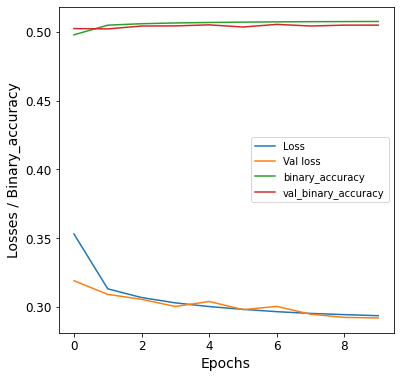

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

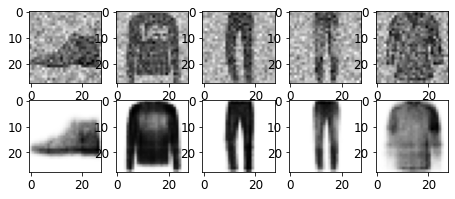

In [ ]:
# Plot the reconstructed images
tf.random.set_seed(42)
np.random.seed(42)

noise = GaussianNoise(0.2)
show_reconstructions(denoising_autoencoder, images=noise(X_test, training=True))
plt.show()

## With Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = Sequential()
dropout_encoder.add( Flatten(input_shape=[28,28]) )
dropout_encoder.add( Dropout(0.5) )
dropout_encoder.add( Dense(100, activation='selu') )
dropout_encoder.add( Dense(30, activation='selu'))

dropout_decoder = Sequential()
dropout_decoder.add( Dense(100, activation='selu', input_shape=[30]) )
dropout_decoder.add( Dense(28*28, activation='sigmoid') )
dropout_decoder.add( Reshape([28,28]) )

dropout_autoencoder = Sequential([dropout_encoder, dropout_decoder])
dropout_autoencoder.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=1.0), metrics=['binary_accuracy'])

In [ ]:
history = dropout_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1563/1563 [==============================] - 6s 3ms/step - loss: 0.4130 - binary_accuracy: 0.4825 - val_loss: 0.3209 - val_binary_accuracy: 0.5017
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3212 - binary_accuracy: 0.5037 - val_loss: 0.3124 - val_binary_accuracy: 0.5013
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3142 - binary_accuracy: 0.5048 - val_loss: 0.3080 - val_binary_accuracy: 0.5019
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3095 - binary_accuracy: 0.5060 - val_loss: 0.3046 - val_binary_accuracy: 0.5022
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3075 - binary_accuracy: 0.5053 - val_loss: 0.3018 - val_binary_accuracy: 0.5030
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3051 - binary_accuracy: 0.5061 - val_loss: 0.3008 - val_binary_accuracy: 0.5032
Epoch 7/10
1563/1563 [==============================

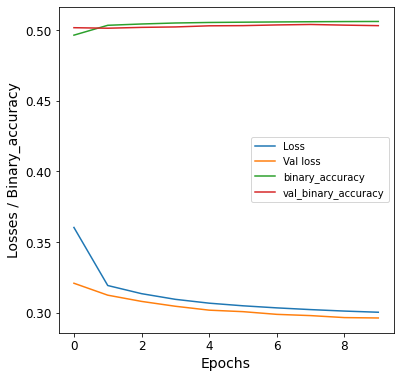

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

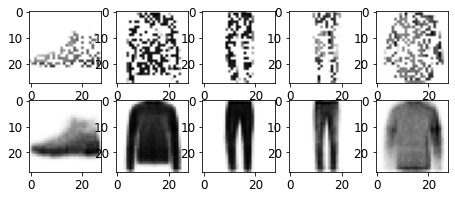

In [ ]:
# Plot the reconstructed images
tf.random.set_seed(42)
np.random.seed(42)

dropout = Dropout(0.5)
show_reconstructions(dropout_autoencoder, images=dropout(X_test, training=True))
plt.show()